## ALIQUOT SEQUENCES - Group 5

In [21]:
# Imports
import math as m
import numpy as np
import matplotlib.pyplot as plt 

# Set default values for K, I, and the maximum n value
K_norm = 30

I_norm = 1e9

n_max = 20000



## Prime sieve and prime factors functions



The function `prime_sieve` helps to find all the prime numbers up to a number $n$. This function is an efficient and fast way to obtain the primes especially for large $n$.


How the Prime Sieve algortihm works in theory:


**1.** Creates a list of consecutive integers from $2$ to $n$, the list starts with $2$ and marks all the multiples of that number (but not itself) as composite.


**2.** It then moves onto the next smallest unmarked number($3..5..7$) and does the same as before, repeating itself until it hits $\sqrt{n}$ and the rest of the unmarked numbers in the list are prime.


`prime_sieve` helps to make the `get_prime_factors` and , thus, the `s(n)` function quicker.

In [22]:
# Prime sieve is an efficient way to find all the primes up to (and including) n
def prime_sieve(maximum=n_max):

    # There are no primes less than 2
    if maximum < 2:
        return None

    # Will create a list of True or False values corresponding to whether the index is a prime number
    # e.g. 3 is a prime number so the value in the 3rd index (4th position) will be true by the end of the function
    prime_mask = [True for _ in range(maximum+1)]

    # 0 and 1 are not prime
    prime_mask[0], prime_mask[1] = False, False

    # Only need to check up to root n
    for p in range(2, int(m.sqrt(maximum)) + 1):
        if prime_mask[p]:
            # go over multiples of each prime number, which will not be prime, and so set value in prime_mask to False
            for i in range(p*p, maximum+1, p):
                prime_mask[i] = False

    # change prime_mask into a numpy array so we can use a boolean mask
    prime_mask = np.array(prime_mask)

    # generate the array of numbers up to n and apply boolean mask to create array of prime numbers
    return np.array([i for i in range(maximum+1)])[prime_mask]


# PRIMES calculated using prime sieve up to the largest n we are going up to, divided by 2
# We can stop here as n cannot have a prime factor larger than n/2
# this can then be used to calculate s(n) for ALL the ns up to n_max, instead of prime_sieve being called for every n
PRIMES = prime_sieve(int(n_max/2) + 1)

The sum of proper divisors function (`s(n)`) relies heavily on `get_prime_factors`, as the classic formula for it is based on prime factorization.

In [23]:
# Using the PRIMES list get the prime factors of a umber n
def get_prime_factors(n):

    primes = PRIMES

    # create an empty dictionary of prime factors
    # we will store this is prime : exponent pairs
    # e.g. n=12 will have prime_factors = {2 : 2, 3 : 1} as 12 = 2^2 x 3
    prime_factors = {}

    # go through each prime to check if it's a divisor of n
    for prime in primes:

        # Only need to check primes up to root n
        # There may be 1 prime bigger than root n,we will deal with this at the end
        if prime**2 > n:
            break

        # check if prime divides n and add to dictionary if it does
        if n % prime == 0:
            prime_factors[int(prime)] = 1

            # now we set n to n / prime so we dont count the same prime factor more than once
            n = n / prime

            # check if this new n is still divisible by the same prime.
            # For as long as it works keep increasing the exponent value assigned to the prime, and dividing n
            while n % prime == 0:
                prime_factors[int(prime)] += 1
                n = n / prime

        # if n reaches 1 we can stop early as we know we have found the prime factorisation of n
        if n == 1:
            break

    # now we check for the potential prime factor bigger than root n.
    # If we have checked all the primes up to root n and still haven't found all the prime factors,
    # we must be left with the last prime factor as n
    if n > 1:
        prime_factors[int(n)] = 1

    # return our completed list of prime factors
    return prime_factors

## CORE 1 - The s(n) function 

We can use the **prime factors** to then find the **sum of divisors** for a given $n$ using the formula:

$$
\sigma(n) = \prod_{i=1}^{k} \left( \frac{p_i^{a_i + 1} - 1}{p_i - 1} \right)
$$

Where $p_i$ are the prime factors and $a_i$ are the powers of the prime factors.

The **sum of proper divisors** is then calculated using the forumla:

$$
s(n) = \sigma(n) - n
$$

The computation of these formulas have been carried out below.




In [24]:
# Calculate s(n)
def s(n):

    # 1 has no proper divisors
    if n == 1:
        return 0

    # the following uses the formula: (insert in latex later)
    # to calculate the sum of all the factors of n using only its prime factors
    total = 1

    primes = get_prime_factors(n).items()

    for prime, power in primes:
        total *= (prime**(power+1) - 1)/(prime - 1)

    # return s(n)
    return total - n

## Examples of the `s(n)` function 

In [25]:
print('The sum of proper divisors of 10 is', s(10))
print('The sum of proper divisors of 300 is', s(300))
print('The sum of proper divisors of 24972395623 is', s(24972395623))

The sum of proper divisors of 10 is 8.0
The sum of proper divisors of 300 is 568.0
The sum of proper divisors of 24972395623 is 4343641457.0


## CORE 2,3,4 - Aliquot sequence function

An Aliquot sequence of a number n, starts with itself and then the terms following it aee the sum of proper divisors of the immediate previous term. We can define it as:

$$
A_n = \{\,n,\, s(n),\, s^2(n),\, s^3(n),\, \ldots \,\}
$$

**Example:**

$$
A_{12} = \{\,12,\,16,\,15,\,9,\,4,\,3,\,0,\}
$$

Within our `aliq_seq` function we explore the different outcomes a sequence can have.

**1.** The sequence can **loop** for example $$A_{220} = \{\,220,\,284,\,220,\,284,\,220,\,\ldots \,\}$$

**2.** The sequence can **reach 0 then terminate** as seen in the $A_{12}$ example above 

**3.** Finally, the sequence can **continue on forever** especially when $n$ is a large number the sequence is less likely to loop or reach 0.

To counteract the possibility of a sequence diverging we have put in Parameters $k$ and $i$ where $k$ is the max amount of terms a sequence can have before terminating and $i$ is the largest number a term can be before termina

In [26]:
#------------------------core 2--------------------------------
# Calculate the aliquot sequence of n
def aliq_seq(n, K=K_norm, I=I_norm):

    # n will be the first element of its aliquot sequence
    seq = [n]

    # make an empty set to record all the s(n)s in order to detect loops
    seen = set()

    curr_n = n
    # loop max k times to compute and check each s(n)
    # return always ends the function so no more code will run after one of the checks is 'failed'
    for k in range(K - 1):
        # check if sequence is terminated
        if curr_n == 0:
            return seq, 'terminated'

        # check if number is bigger than specified i
        if curr_n >= I:
            return seq, 'I reached'
#------------------------core 3--------------------------------
        # check if sequence has looped
        if curr_n in seen:
            return seq, 'looped'

        # add n to sequence of seen numbers
        # has to be done after checks otherwise it will always think it loops
        seen.add(curr_n)

        # calculate next term of sequence if n has 'passed' all tests
        curr_n = s(curr_n)
        seq.append(int(curr_n))

    # If loop finished and has computed all k s(n), the sequence is finished (up to where we have decided to stop)
    # so returns sequence and the status that k has been reached
    return seq, 'K reached'
#------------------------core 4--------------------------------
# make dictionary to count the number of types of each sequence
counts = {'terminated': 0, 'looped': 0, 'I reached': 0, 'K reached': 0}

# generate sequences up to 20000 (or whatever n_max is) and update counts dictionary
for i in range(1, n_max + 1):
    status = aliq_seq(i)[1]
    counts[status] += 1

# ouput counts (for testing)
print(counts)

{'terminated': 15490, 'looped': 446, 'I reached': 736, 'K reached': 3328}


## Classification of Aliquot Sequences for $n < 20,000$

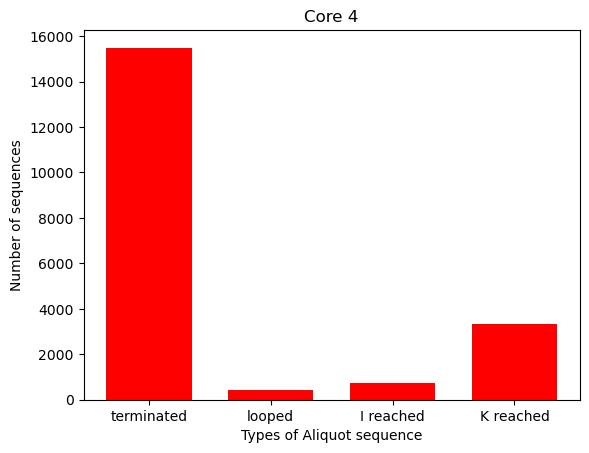

In [38]:
types = list(counts.keys())
values = list(counts.values())



plt.bar(types,values,width=0.7,color = 'red')
plt.title('Core 4')
plt.xlabel('Types of Aliquot sequence')
plt.ylabel('Number of sequences')

plt.show()

## Example 1
An Aliquot sequence **reaching 0 and terminating**.

In [ ]:
print(aliq_seq(10,K_norm,I_norm))

## Example 2 
An Aliquot sequence terminating when $s^j(n) > I$ when $I = 1 \times 10^{9}$

In [ ]:
print(aliq_seq(123846392,K_norm,I_norm))

## Example 3 
An Aliquot sequence terminating when the number of terms in $A_n > K$ when $K = 30$

In [ ]:
print(aliq_seq(276,K_norm,I_norm))

## Example 4 
An Aliquot sequence terminating when an **infintite loop** begins.

In [ ]:
print(aliq_seq(562,K_norm,I_norm))
print(aliq_seq(6,K_norm,I_norm))